# 轮廓检测与识别

下面的图像为大写的字母标识，是本节实验的对象。通过本节实验完成字母标识的检测和识别项目，并且熟悉轮廓和轮廓矩的使用及原理。

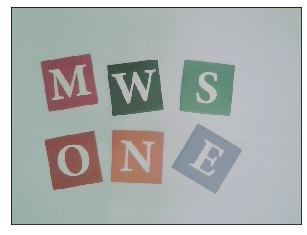

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt 

img = cv.imread("./data/alphablock.jpg")

plt.imshow(img[:,:,::-1])
plt.xticks([]),plt.yticks([])
plt.show()

## 边缘检测
使用Canny检测边缘法检测物块边缘，在这之前需要使用高斯滤波器减少噪声。

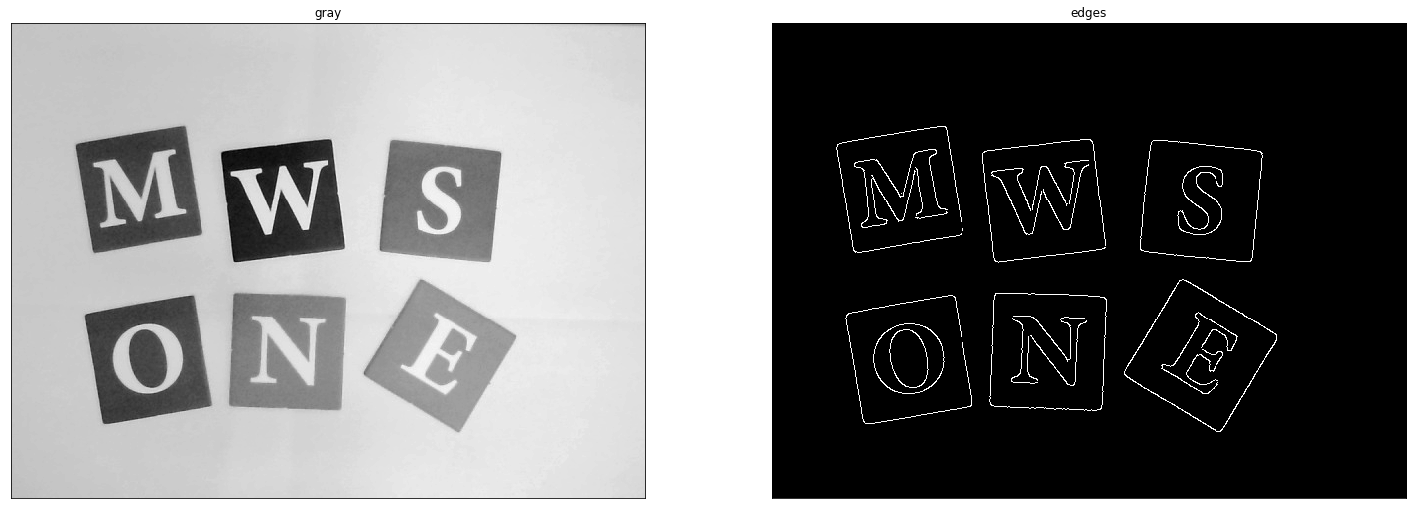

In [2]:
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gaussian = cv.GaussianBlur(gray,(9,9),2)
edges = cv.Canny(gaussian,20,50)

plt.figure(figsize=(25,10))
plt.subplot(121),plt.imshow(gray,cmap="gray"),plt.title("gray")
plt.xticks([]),plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap="gray"),plt.title("edges")
plt.xticks([]),plt.yticks([])
plt.show()


## 轮廓查找
可以看到检测到的边缘信息往往会由于光照、相机配置、噪声等原因，造成得到的边缘不连续。这里我们可以通过使用形态学处理，将得到的边缘图像膨胀。需要注意的是，这样会造成原来的单条边缘得到内外两条边缘。如下所示：

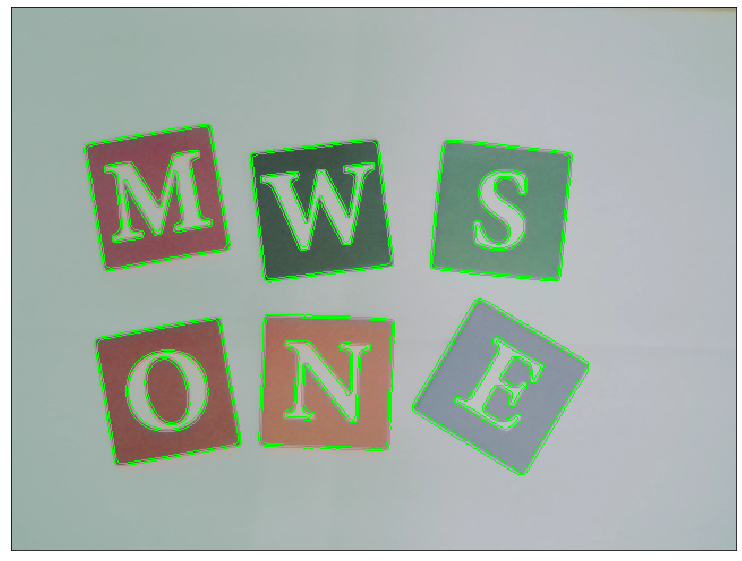

In [3]:
kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3)) #矩形结构
dilate = cv.morphologyEx(edges,cv.MORPH_DILATE,kernel)
contours, hierarchy = cv.findContours(dilate,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
copyimg = img.copy()
cv.drawContours(copyimg, contours, -1, (0, 255, 0), 1)

plt.figure(figsize=(20,10))
plt.imshow(copyimg[:,:,::-1])
plt.xticks([]),plt.yticks([])
plt.show()

## 轮廓筛选

通过获取轮廓的周长、面积、长宽比、筛选轮廓。

使用$cv.approxPolyDP()$函数，根据轮廓的周长自适应多边形拟合。通过判断结果的角点数，可以判断多边形的形状。

使用$cv.findContours()$函数后，它返回查找的轮廓列表，以及对应的轮廓层级信息列表。这里使用的轮廓查找方法为**cv.RETR_TREE**方法，返回的轮廓层级列表对应值分别代表的是：

[<相同轮廓层级的下一个轮廓>,<相同轮廓层级的前一个轮廓>,<第一个子轮廓>,<父轮廓>]

通过轮廓层级的筛选，可以得到物块的轮廓，以及字母的轮廓信息。这里使用两个变量将筛选后的轮廓储存，在后面使用。

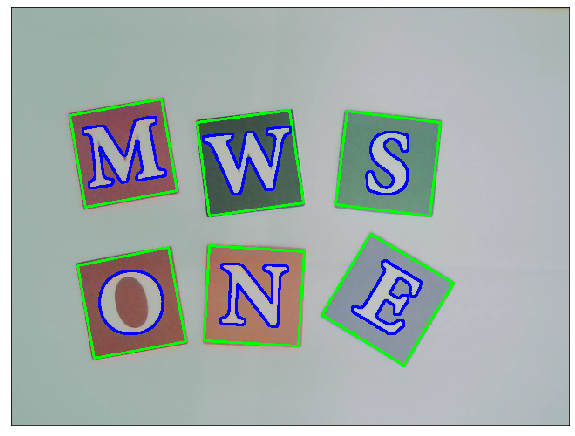

In [4]:
# 物块
block_contours = []
alpha_contours = []

copyimg = img.copy()
for i in range(len(contours)):
    cnt = contours[i]
    # 父轮廓
    parent_cnt = hierarchy[0][i][3]
    # 第一个子轮廓
    first_child_cnt = hierarchy[0][i][2]
    # 相同轮廓层级的前一个
    previous = hierarchy[0][i][1]
    # 相同轮廓层级的下一个
    next = hierarchy[0][i][0]
    # 轮廓面积
    area = cv.contourArea(cnt)
    # 轮廓周长
    perimeter = cv.arcLength(cnt,True)
    # 多边形拟合
    approx = cv.approxPolyDP(cnt,0.02*perimeter,True)
    # 获得轮廓的长宽比
    x,y,w,h = cv.boundingRect(approx)
    aspect_ratio = float(w)/h
    if len(approx) == 4 and aspect_ratio >= 0.9 and aspect_ratio <= 1.1 and area > 1000:
        # 轮廓层级判断，取内边。
        if previous == -1 and next == -1 and parent_cnt != -1:
            cv.polylines(copyimg,[approx],True,(0,255,0),2)
            # 得到内边的下一级轮廓(提取字母)
            cv.polylines(copyimg,[contours[first_child_cnt]],True,(255,0,0),2)
            block_contours.append(cnt)
            alpha_contours.append(contours[first_child_cnt])

plt.figure(figsize=(10,10))
plt.imshow(copyimg[:,:,::-1])
plt.xticks([]),plt.yticks([])
plt.show()


## 轮廓识别
轮廓识别基于$cv.matchShape()$形状匹配函数实现，所以我们需要提前创建一个字母轮廓样本。首先将上面的内容封装成一个函数，便于去添加多个样本。

In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


def alpha_block_detect(image):
    gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    gaussian = cv.GaussianBlur(gray,(9,9),2)
    edges = cv.Canny(gaussian,20,50)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3)) #矩形结构
    dilate = cv.morphologyEx(edges,cv.MORPH_DILATE,kernel)
    contours, hierarchy = cv.findContours(dilate,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    # 物块
    block_contours = []
    alpha_contours = []
    for i in range(len(contours)):
        cnt = contours[i]
        # 父轮廓
        parent_cnt = hierarchy[0][i][3]
        # 第一个子轮廓
        first_child_cnt = hierarchy[0][i][2]
        # 相同轮廓层级的前一个
        previous = hierarchy[0][i][1]
        # 相同轮廓层级的下一个
        next = hierarchy[0][i][0]
        # 轮廓面积
        area = cv.contourArea(cnt)
        # 轮廓周长
        perimeter = cv.arcLength(cnt,True)
        # 多边形拟合
        approx = cv.approxPolyDP(cnt,0.02*perimeter,True)
        # 获得轮廓的长宽比
        x,y,w,h = cv.boundingRect(approx)
        aspect_ratio = float(w)/h
        
        if len(approx) == 4 and aspect_ratio >= 0.9 and aspect_ratio <= 1.1 and area > 1000:
            # 轮廓层级判断，取内边。
            if previous == -1 and next == -1 and parent_cnt != -1:
                cv.polylines(image,[approx],True,(0,255,0),2)
                # 得到内边的下一级轮廓(提取字母)
                cv.polylines(image,[contours[first_child_cnt]],True,(255,0,0),2)
                block_contours.append(cnt)
                alpha_contours.append(contours[first_child_cnt])
    plt.imshow(image[:,:,::-1])
    plt.xticks([]),plt.yticks([])
    plt.show()
    return block_contours,alpha_contours

这里已经单独拍摄了W、M、S、N、O标识的图像，使用上面封装后的函数得到字母外轮廓。并且将$np.savez$保存样本列表。

alpha W


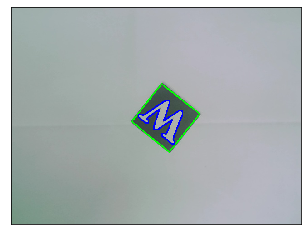

alpha M


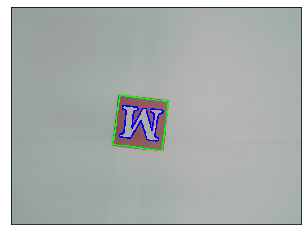

alpha S


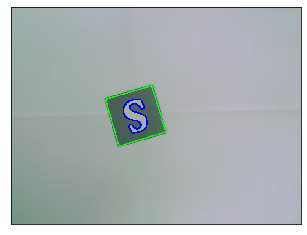

alpha N


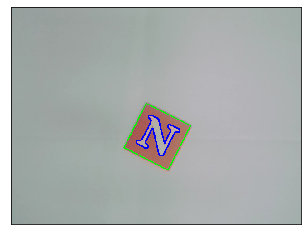

alpha O


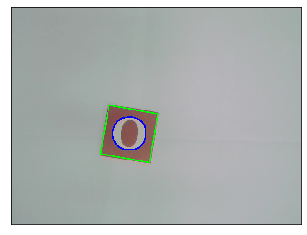

succes save file as ./data/alpha_sample.npz


In [6]:
import glob

file_path = glob.glob("./data/mark_*.jpg")

alpha_sample = []
alpha_name = []
for file in file_path:
    print("alpha {}".format(file[12]))
    image = cv.imread(file)
    box,alpha = alpha_block_detect(image)
    alpha_sample.append(alpha)
    alpha_name.append(file[12])
np.savez("./data/alpha_sample.npz",sample=alpha_sample,name=alpha_name)
print("succes save file as {}".format("./data/alpha_sample.npz"))
    

这里用到了在轮廓检测部分我们储存的两个列表，分别是物块轮廓、字母轮廓。将字母轮廓与样本进行配对，然后对结果进行可视化。

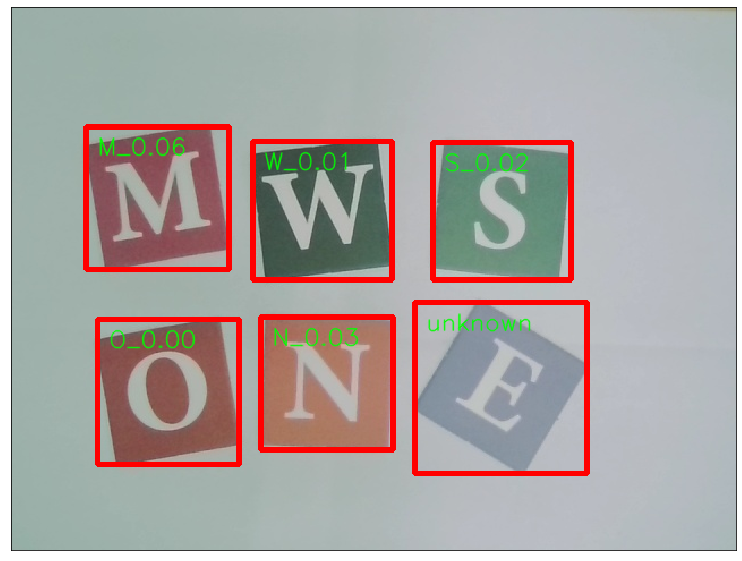

In [7]:
copyimg = img.copy()

sample = np.load("./data/alpha_sample.npz",allow_pickle=True)

for i in range(len(block_contours)):
    block_contour = block_contours[i]
    alpha_contour = alpha_contours[i]
    # 形状识别
    predict = []
    for sap in sample["sample"]:
        ret = cv.matchShapes(alpha_contour,sap[0],1,0.0)
        predict.append(ret)
    min_index = np.argmin(predict)
    if predict[min_index] < 0.1:
        label = sample["name"][min_index]+"_{:.2f}".format(predict[min_index])
    else:
        label = "unknown"
    # 计算物块的外接矩形
    x,y,w,h = cv.boundingRect(block_contour)
    cv.rectangle(copyimg,(x,y),(x+w,y+h),(0,0,255),4)
    cv.putText(copyimg,label,(x+10,y+25),cv.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1,cv.LINE_AA)

plt.figure(figsize=(20,10))
plt.imshow(copyimg[:,:,::-1])
plt.xticks([]),plt.yticks([])
plt.show()

## 使用摄像头实时检测与识别

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


def alpha_block_detect(image):
    gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    gaussian = cv.GaussianBlur(gray,(9,9),2)
    edges = cv.Canny(gaussian,20,50)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3)) #矩形结构
    dilate = cv.morphologyEx(edges,cv.MORPH_DILATE,kernel)
    contours, hierarchy = cv.findContours(dilate,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    # 物块
    block_contours = []
    alpha_contours = []
    for i in range(len(contours)):
        cnt = contours[i]
        # 父轮廓
        parent_cnt = hierarchy[0][i][3]
        # 第一个子轮廓
        first_child_cnt = hierarchy[0][i][2]
        # 相同轮廓层级的前一个
        previous = hierarchy[0][i][1]
        # 相同轮廓层级的下一个
        next = hierarchy[0][i][0]
        # 轮廓面积
        area = cv.contourArea(cnt)
        # 轮廓周长
        perimeter = cv.arcLength(cnt,True)
        # 多边形拟合
        approx = cv.approxPolyDP(cnt,0.02*perimeter,True)
        # 获得轮廓的长宽比
        x,y,w,h = cv.boundingRect(approx)
        aspect_ratio = float(w)/h
        
        if len(approx) == 4 and aspect_ratio >= 0.9 and aspect_ratio <= 1.1 and area > 1000:
            # 轮廓层级判断，取内边。
            if previous == -1 and next == -1 and parent_cnt != -1:
                block_contours.append(cnt)
                alpha_contours.append(contours[first_child_cnt])
    return block_contours,alpha_contours

def contour_recognition(contour,conf):
    sample = np.load("./data/alpha_sample.npz",allow_pickle=True)
    predict = []
    for sap in sample["sample"]:
        ret = cv.matchShapes(contour,sap[0],1,0.0)
        predict.append(ret)
    min_index = np.argmin(predict)
    if predict[min_index] < conf:
        label = sample["name"][min_index]
    else:
        label = "unknown"
    return predict,label

In [9]:
cap = cv.VideoCapture(0)
while True:
    if not cap.isOpened():
        print("no found device")
        break
    ret,frame = cap.read()
    if ret == False:
        print("frame read failure")    
        break
    block_contours,alpha_contours = alpha_block_detect(frame)
    for i in range(len(block_contours)):
        block_contour = block_contours[i]
        alpha_contour = alpha_contours[i]
        predict,label = contour_recognition(alpha_contour,0.1)
        # 计算物块的外接矩形
        x,y,w,h = cv.boundingRect(block_contour)
        cv.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
        cv.putText(frame,label,(x+10,y+25),cv.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1,cv.LINE_AA)   
    cv.imshow("frame",frame)
    key = cv.waitKey(10)
    if key == 27:
        break

cap.release()
cv.destroyAllWindows()

![](images/2023-08-29-14-07-52.png)